In [7]:
import rawpy
import imageio
import matplotlib.pyplot as plt
import numpy as np

In [64]:
dngFile = 'd:\\Data\\F1_Data\\template.dng'
with rawpy.imread(dngFile) as r:
    rgb = r.postprocess( no_auto_bright=True )

In [9]:
# RGB <-> YUV
# https://gist.github.com/Quasimondo/c3590226c924a06b276d606f4f189639
# see also https://stackoverflow.com/questions/43983265/rgb-to-yuv-conversion-and-accessing-y-u-and-v-channels
def RGB2YUV( rgb ):    
    '''
     - input is a RGB numpy array with shape (height,width,3), can be uint,int, float or double, 
       values expected in the range 0..255
     - output is a double YUV numpy array with shape (height,width,3), values in the range 0..255    
    '''   
    m = np.array([[ 0.29900, -0.16874,  0.50000],
                 [0.58700, -0.33126, -0.41869],
                 [ 0.11400, 0.50000, -0.08131]])
    # see https://www.tutorialspoint.com/numpy/numpy_dot.htm for using np.dot
    yuv = np.dot(rgb,m)
    yuv[:,:,1:]+=128.0
    return yuv

def YUV2RGB( yuv ):
    '''
     - input is an YUV numpy array with shape (height,width,3) can be uint,int, float or double,  
       values expected in the range 0..255
     - output is a double RGB numpy array with shape (height,width,3), values in the range 0..255    
    '''
    m = np.array([[ 1.0, 1.0, 1.0],
                 [-0.000007154783816076815, -0.3441331386566162, 1.7720025777816772],
                 [ 1.4019975662231445, -0.7141380310058594 , 0.00001542569043522235] ])
    
    rgb = np.dot(yuv,m)
    rgb[:,:,0]-=179.45477266423404
    rgb[:,:,1]+=135.45870971679688
    rgb[:,:,2]-=226.8183044444304
    return rgb

In [29]:
yuv = RGB2YUV(rgb).astype(np.uint8)  # convert to uint8 will lose precison

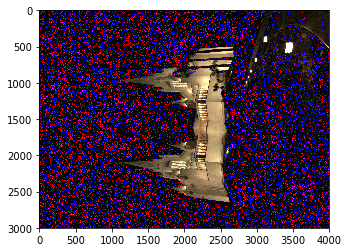

In [41]:
rgb_2 = YUV2RGB(yuv)
plt.imshow(rgb_2.astype(np.uint8))
#plt.imshow(yuv[:,:,0], cmap='gray', vmin=0, vmax=255)
#plt.imshow( np.stack((yuv[:,:,1],)*3, -1))

In [31]:
import cv2

In [32]:
img_yuv = cv2.cvtColor(rgb, cv2.COLOR_RGB2YUV)

In [48]:
img_yuv.dtype

dtype('uint8')

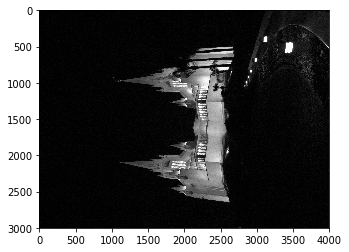

In [39]:
plt.imshow(img_yuv[:,:,0], cmap='gray', vmin=0, vmax=255)

In [36]:
img_rgb = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)

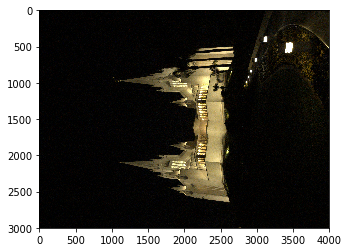

In [37]:
plt.imshow(img_rgb)

In [100]:
def LutToneRgb(rgb, lut):
    yuv = cv2.cvtColor(rgb, cv2.COLOR_RGB2YUV)
    # LUT Map numpy matrix: 
    # https://stackoverflow.com/questions/14448763/is-there-a-convenient-way-to-apply-a-lookup-table-to-a-large-array-in-numpy
    y, u, v = cv2.split(yuv)  # costly operation
    
    y_mapped = lut[y]
    plt.imshow(y_mapped, cmap='gray', vmin=0, vmax=255)
    
    # handle divide by zero
    y_mapped[y==0] = 1    
    y[y==0] = 1
    
    ratio = y_mapped.astype(np.float64) / y.astype(np.float64)
    print ratio

    u_mapped = u.astype(np.float64) * ratio
    u_mapped = u_mapped.astype(np.uint8)
    
    v_mapped = v.astype(np.float64) * ratio
    v_mapped = v_mapped.astype(np.uint8)    

    # cv2.merge and split are costly according to
    # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_basic_ops/py_basic_ops.html
    return cv2.cvtColor(cv2.merge((y_mapped, u_mapped, v_mapped),-1), cv2.COLOR_YUV2RGB)

[[ 4.          4.          4.         ...,  2.4         2.4         2.41666667]
 [ 4.          4.          1.         ...,  2.34615385  2.5         2.43478261]
 [ 4.          4.          4.         ...,  2.52380952  2.5         2.4       ]
 ..., 
 [ 4.          1.          4.         ...,  1.          1.          4.        ]
 [ 4.          1.          1.         ...,  4.          4.          4.        ]
 [ 4.          4.          4.         ...,  4.          4.          4.        ]]


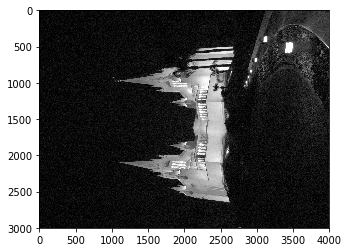

In [101]:
#lut = np.array([i for i in xrange(256)], dtype=np.uint8)
maxVal = 255
lut = np.array(range(maxVal+1))
gamma = 2.2
degamma = 1.0/2.2
scale = maxVal / np.power(maxVal, degamma)
lut[1:] = np.power( lut[1:], degamma ) * scale
lut = lut.astype(np.uint8)
lut = np.array([0., 4., 8., 12., 16., 19., 22., 24., 27., 29., 32., 34., 36., 38., 40., 42., 44.,
                                   46., 48., 49., 51., 53., 55., 56., 58., 60., 61., 63., 64., 66., 68., 69., 70.,
                                   72., 73., 75., 76., 77., 79., 80., 82., 83., 84., 85., 87., 88., 89., 90., 92.,
                                   93., 94., 95., 96., 98., 99., 100., 101., 102., 104., 105., 106., 107., 108., 109.,
                                   110., 111., 112., 113., 114., 116., 117., 118., 119., 120., 121., 122., 123., 124.,
                                   125., 126., 127., 128., 129., 130., 131., 132., 133., 134., 134., 135., 136., 137.,
                                   138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 148., 149., 150.,
                                   151., 152., 153., 154., 154., 155., 156., 157., 158., 159., 160., 160., 161., 162.,
                                   163., 164., 164., 165., 166., 167., 168., 169., 170., 170., 171., 172., 172., 173.,
                                   174., 175., 176., 176., 177., 178., 179., 180., 180., 181., 182., 183., 184., 184.,
                                   185., 186., 186., 187., 188., 189., 190., 190., 191., 192., 192., 193., 194., 194.,
                                   195., 196., 197., 197., 198., 199., 200., 200., 201., 202., 202., 203., 204., 205.,
                                   205., 206., 207., 207., 208., 209., 209., 210., 211., 211., 212., 213., 214., 214.,
                                   215., 216., 216., 217., 218., 218., 219., 219., 220., 221., 222., 222., 223., 223.,
                                   224., 225., 225., 226., 227., 227., 228., 229., 229., 230., 230., 231., 232., 232.,
                                   233., 234., 234., 235., 236., 236., 237., 237., 238., 239., 239., 240., 240., 241.,
                                   242., 242., 243., 244., 244., 245., 246., 246., 247., 247., 248., 248., 249., 250.,
                                   250., 251., 252., 252., 253., 253., 254., 254., 255., 255.]).astype(np.uint8)
rgb_mapped = LutToneRgb(rgb, lut)

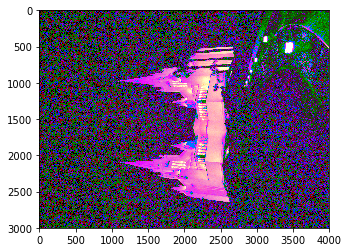

In [99]:
plt.imshow(rgb_mapped)

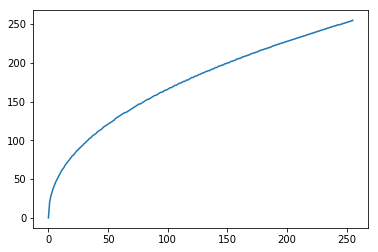

In [89]:
plt.plot(lut)